In [1]:
### Environment setup
import sys
sys.path.append('/content')
from src.fluvius import WaterData, WaterStation
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import geopandas as gpd
import fsspec
from pystac_client import Client
import planetary_computer as pc
import os
import folium
from shapely.geometry import shape

import matplotlib.pyplot as plt
# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)
env_vars = !cat /content/.env

for var in env_vars:
    key, value = var.split(' = ')
    os.environ[key] = value

#################  set up ####################
data_source = 'itv'
container = f'{data_source}-data'

storage_options={'account_name':os.environ['ACCOUNT_NAME'],\
                 'account_key':os.environ['BLOB_KEY']}
fs = fsspec.filesystem('az',\
                       account_name=storage_options['account_name'],\
                       account_key=storage_options['account_key'])

In [2]:
df = pd.read_json('az://app/station_metadata.json',\
          storage_options=storage_options)
ds = pd.read_json('az://modeling-data/fluvius_data.json',\
                 storage_options=storage_options)
ds = ds.replace('--',np.nan).dropna()
ds['SSC (mg/L)'] = ds['SSC (mg/L)'].astype(float)
ds['Q (m3/s)'] = ds['Q (m3/s)'].astype(float)
ds.julian = ds.julian.astype(float)

In [3]:
def generate_map(df):
    '''
    plots web map using folium
    '''
    cx, cy = np.mean(df['Longitude']),np.mean(df['Latitude'])
    plot_map = folium.Map(location=[cy, cx],\
        zoom_start=2,\
        tiles='CartoDB positron')
    for _, r in df.iterrows():
        folium.Marker(location=[r['Latitude'], r['Longitude']],\
            #popup=f"{r['site_no']}:\n{r['station_name']}").add_to(self.plot_map)
            popup=f"Site: {r['site_no']}").add_to(plot_map)
        #polygons = gpd.GeoSeries(r['buffer_geometry'])
        #geo_j = polygons.to_json()
        #geo_j = folium.GeoJson(data=geo_j,style_function=lambda x: {'fillColor': 'orange'})
        #geo_j.add_to(plot_map)
    tile = folium.TileLayer(\
            tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',\
            attr = 'Esri',\
            name = 'Esri Satellite',\
            overlay = False,\
            control = True).add_to(plot_map)

    return plot_map

In [4]:
m = generate_map(df)

In [5]:
#now use bokeh to generate some averaging and distribution plots
''' Present a scatter plot with linked histograms on both axes.
Use the ``bokeh serve`` command to run the example by executing:
    bokeh serve selection_histogram.py
at your command prompt. Then navigate to the URL
    http://localhost:5006/selection_histogram
in your browser.
'''

import numpy as np

from bokeh.layouts import gridplot
from bokeh.models import BoxSelectTool, LassoSelectTool
from bokeh.plotting import curdoc, figure
from bokeh.io import output_notebook, show

output_notebook()

# create three normal population samples with different parameters
#x1 = ds['julian']
#y1 = ds['SSC (mg/L)']

x = np.log(ds['Q (m3/s)'])
y = np.log(ds['SSC (mg/L)'])

#x3 = ds['sentinel-2-l2a_R'] 
#y3 = ds['SSC (mg/L)']

#x = np.concatenate((x1, x2, x3))
#y = np.concatenate((y1, y2, y3))

TOOLS="pan,wheel_zoom,box_select,lasso_select,reset"

# create the scatter plot
p = figure(tools=TOOLS, width=600, height=600, min_border=10, min_border_left=50,
           toolbar_location="above", x_axis_location=None, y_axis_location=None,
           title="Linked Histograms")
p.background_fill_color = "#fafafa"
p.select(BoxSelectTool).select_every_mousemove = False
p.select(LassoSelectTool).select_every_mousemove = False

r = p.scatter(x, y, size=3, color="#3A5785", alpha=0.6)

# create the horizontal histogram
hhist, hedges = np.histogram(x, bins=20)
hzeros = np.zeros(len(hedges)-1)
hmax = max(hhist)*1.1

LINE_ARGS = dict(color="#3A5785", line_color=None)

ph = figure(toolbar_location=None, width=p.width, height=200, x_range=p.x_range,
            y_range=(-hmax, hmax), min_border=10, min_border_left=50, y_axis_location="right")
ph.xgrid.grid_line_color = None
ph.yaxis.major_label_orientation = np.pi/4
ph.background_fill_color = "#fafafa"

ph.quad(bottom=0, left=hedges[:-1], right=hedges[1:], top=hhist, color="white", line_color="#3A5785")
hh1 = ph.quad(bottom=0, left=hedges[:-1], right=hedges[1:], top=hzeros, alpha=0.5, **LINE_ARGS)
hh2 = ph.quad(bottom=0, left=hedges[:-1], right=hedges[1:], top=hzeros, alpha=0.1, **LINE_ARGS)

# create the vertical histogram
vhist, vedges = np.histogram(y, bins=20)
vzeros = np.zeros(len(vedges)-1)
vmax = max(vhist)*1.1

pv = figure(toolbar_location=None, width=200, height=p.height, x_range=(-vmax, vmax),
            y_range=p.y_range, min_border=10, y_axis_location="right")
pv.ygrid.grid_line_color = None
pv.xaxis.major_label_orientation = np.pi/4
pv.background_fill_color = "#fafafa"

pv.quad(left=0, bottom=vedges[:-1], top=vedges[1:], right=vhist, color="white", line_color="#3A5785")
vh1 = pv.quad(left=0, bottom=vedges[:-1], top=vedges[1:], right=vzeros, alpha=0.5, **LINE_ARGS)
vh2 = pv.quad(left=0, bottom=vedges[:-1], top=vedges[1:], right=vzeros, alpha=0.1, **LINE_ARGS)

layout = gridplot([[p, pv], [ph, None]], merge_tools=False)

curdoc().add_root(layout)
curdoc().title = "Selection Histogram"

def update(attr, old, new):
    inds = new
    if len(inds) == 0 or len(inds) == len(x):
        hhist1, hhist2 = hzeros, hzeros
        vhist1, vhist2 = vzeros, vzeros
    else:
        neg_inds = np.ones_like(x, dtype=np.bool)
        neg_inds[inds] = False
        hhist1, _ = np.histogram(x[inds], bins=hedges)
        vhist1, _ = np.histogram(y[inds], bins=vedges)
        hhist2, _ = np.histogram(x[neg_inds], bins=hedges)
        vhist2, _ = np.histogram(y[neg_inds], bins=vedges)

    hh1.data_source.data["top"]   =  hhist1
    hh2.data_source.data["top"]   = -hhist2
    vh1.data_source.data["right"] =  vhist1
    vh2.data_source.data["right"] = -vhist2

r.data_source.selected.on_change('indices', update)

show(layout)

Loading BokehJS ...

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: autodetected range of [-inf, 10.22918769217543] is not finite

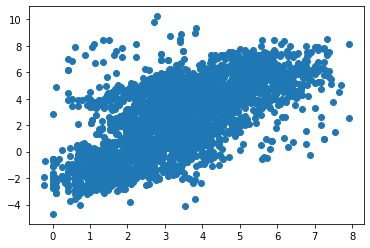

In [6]:
plt.scatter(np.log(ds['SSC (mg/L)']), np.log(ds['Q (m3/s)']))